### Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.

### Importing Libraries

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import seaborn as sns
from PIL import Image


from openTSNE import TSNE

In [113]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.8.0+cu126
Using GPU, device name: Tesla T4


### Loading the MNIST dataset

In [114]:


# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [115]:
batch_size = 60
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [116]:
class MLP(nn.Module):
    def __init__(self, hidden_1, hidden_2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out, x

In [117]:
hidden_1=30
hidden_2=20

In [136]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs,_ = model(images) # Use only the first element of the tuple
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Store predictions and true labels
            _, predicted = torch.max(outputs.data, 1)
            y_train_pred = predicted.cpu().numpy()
            y_train_true = labels.cpu().numpy()
            y_train_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * (correct_train / total_train)
        train_loss = total_train_loss / len(train_loader)

        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0



        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs, _ = model(images) # Use only the first element of the tuple
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                y_test_pred = predicted.cpu().numpy()
                y_test_true = labels.cpu().numpy()
                y_test_prob = F.softmax(outputs, dim=1).cpu().detach().numpy()
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

    return model, train_loss, train_accuracy, test_loss, test_accuracy, y_train_true, y_train_pred, y_train_prob, y_test_true, y_test_pred, y_test_prob

In [137]:
trained_model = MLP(hidden_1, hidden_2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)
print(trained_model)

summary(trained_model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [138]:
trained_model, train_loss, train_accuracy, test_loss, test_accuracy, y_train, y_train_pred, y_train_prob, y_test, y_test_pred, y_test_prob = train_and_evaluate_model(
    trained_model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

Epoch [10/20], Train Loss: 0.094490, Train Accuracy: 97.1300%, Test Loss: 0.131234, Test Accuracy: 96.0000%
Epoch [20/20], Train Loss: 0.054416, Train Accuracy: 98.3117%, Test Loss: 0.124695, Test Accuracy: 96.4700%


In [129]:
def get_hidden_layer_output(model, dataset, device=device):
    model.eval()
    hidden_layer_output = []
    labels = []
    with torch.no_grad():
        for image, label in dataset:
            image = image.to(device).view(1, -1)  # Flatten image
            _, hidden_output = model(image)
            hidden_layer_output.append(hidden_output.squeeze().cpu().numpy())
            labels.append(label)
    return np.array(hidden_layer_output), np.array(labels)


def plot_tsne(tsne_data, labels, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    scatter = ax.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', s=1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('t-SNE Component 1', fontsize=14)
    ax.set_ylabel('t-SNE Component 2', fontsize=14)
    ax.grid(True, alpha=0.5)
    plt.colorbar(scatter, ax=ax, label='Digit Classes')

    plt.tight_layout()

## openTSNE

In [130]:
untrained_model = MLP(hidden_1,hidden_2).to(device)


untrained_model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)

In [139]:
X_trained, y_trained = get_hidden_layer_output(trained_model, test_dataset)
X_untrained, y_untrained = get_hidden_layer_output(untrained_model, test_dataset)

In [ ]:


tsne_trained = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
tsne_untrained = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)

X_trained_tsne = tsne_trained.fit(X_trained)
X_untrained_tsne = tsne_untrained.fit(X_untrained)

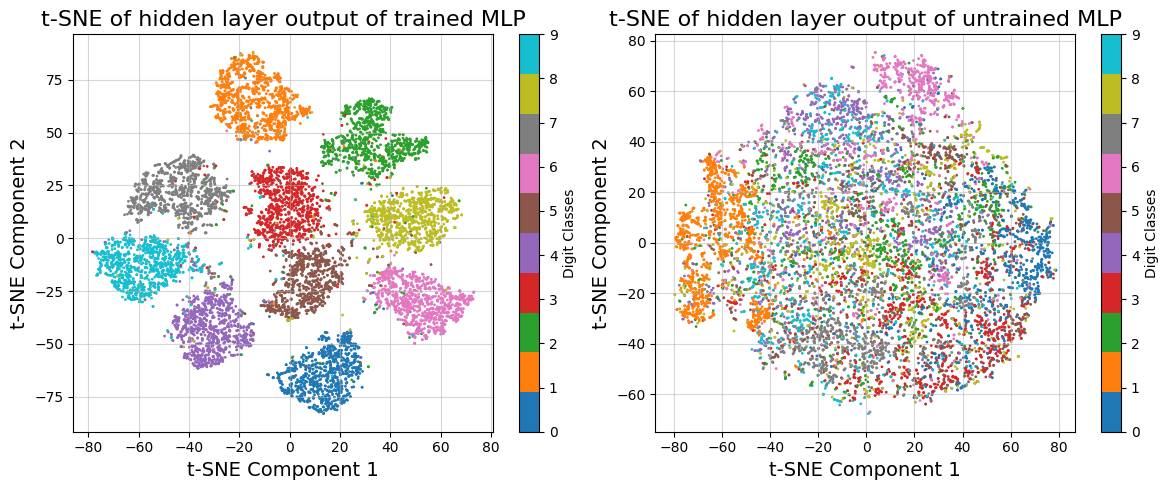

In [141]:
# Plotting t-SNE for trained and untrained models

X_trained_tsne = np.array(X_trained_tsne)
X_untrained_tsne = np.array(X_untrained_tsne)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_tsne(X_trained_tsne, y_trained, 't-SNE of hidden layer output of trained MLP', ax=axes[0])
plot_tsne(X_untrained_tsne, y_untrained, 't-SNE of hidden layer output of untrained MLP', ax=axes[1])

## Observations
### t-SNE Plot of Trained MLP Model

- Distinct Clusters: The t-SNE plot of the trained model shows clear, distinct clusters, where each cluster corresponds to a specific digit (0–9). This demonstrates that the model has learned to group similar samples closely.
- Cluster Separation: The clusters are well-separated, indicating that the model has learned feature representations that effectively differentiate between digit classes.
- Dense Grouping: Within each cluster, points are densely grouped, showing that the model has reduced intra-class variation and is consistently able to identify similar features for each digit.

### t-SNE Plot of Untrained MLP Model
- Lack of Clusters: The t-SNE plot of the untrained model lacks distinct clusters for each digit. Without training, there’s no separation, as the model has not learned any useful features to distinguish between classes.
- Sparse and Mixed Representation: Points from different digit classes are scattered or intermixed randomly. This shows that the untrained model doesn’t have a structured representation of the data and cannot effectively differentiate between classes.

## Conclusion

By comparing these two plots, we conclude that the trained model has learned discriminative features, resulting in better separation and clustering of different digit classes, whereas the untrained model shows no such structure in the feature space.